In [385]:
%matplotlib inline
# for interactive charts use %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import requests
import numpy as np
import datetime
import os.path
from scipy.optimize import curve_fit
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

# Read in data

- Canadian data from [Isha Berry](https://github.com/ishaberry/Covid19Canada)

In [386]:
# Parameters
DAYS_EXTRAPOLATION = 14
DAYS_ANNOTATE = 6
START_DAYS_AFTER = 25
FIT_POINTS = 10
FETCH_ALWAYS = True

In [387]:
url = "https://docs.google.com/spreadsheets/d/1D6okqtBS3S2NRC7GFVHzaZ67DuTw7LX49-fqSLwJyeo/export?format=xlsx"
if FETCH_ALWAYS or datetime.date.today() != datetime.date.fromtimestamp(os.path.getmtime("canada.xlsx")):
    r = requests.get(url)
    with open("canada.xlsx", "wb") as output:
        output.write(r.content)

In [388]:
df = pd.read_excel("canada.xlsx", sheet_name = "Cases", skiprows = range(0, 3), index_col=0)

# Canada-wide cumulative cases

These cumulative calculations do not include recoveries. They should, of course.

In [389]:
def data_aggregate_by_date():
    df_agg = df.groupby("date_report").apply(lambda x: x.count())
    df_agg = df["date_report"].to_frame().groupby("date_report").apply(lambda x: x.count())
    df_agg["date"] = df_agg.index
    idx = pd.date_range(df_agg["date"].min(), df_agg["date"].max())
    df_agg = df_agg.reindex(idx, fill_value=0)
    df_agg["date"] = df_agg.index
    df_agg["days"] = df_agg["date"].apply(lambda date: (date - df_agg["date"].min()).days)
    df_agg["cumulative"] = df_agg["date_report"].to_frame().expanding(1).sum()
    df_agg["cumulative_shift"] = df_agg["cumulative"].shift(1)
    df_agg["growth_rate"] = 100 * df_agg["date_report"] / df_agg["cumulative_shift"]
    return df_agg
    
df_agg = data_aggregate_by_date()

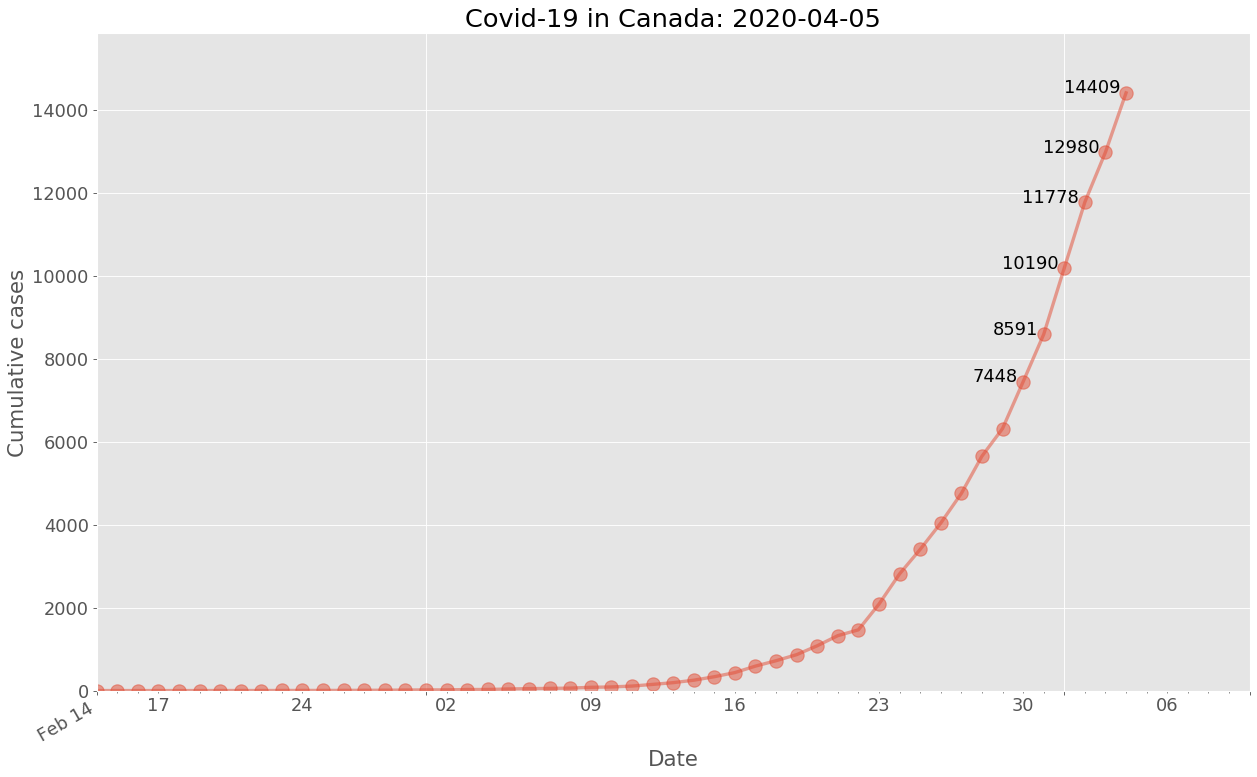

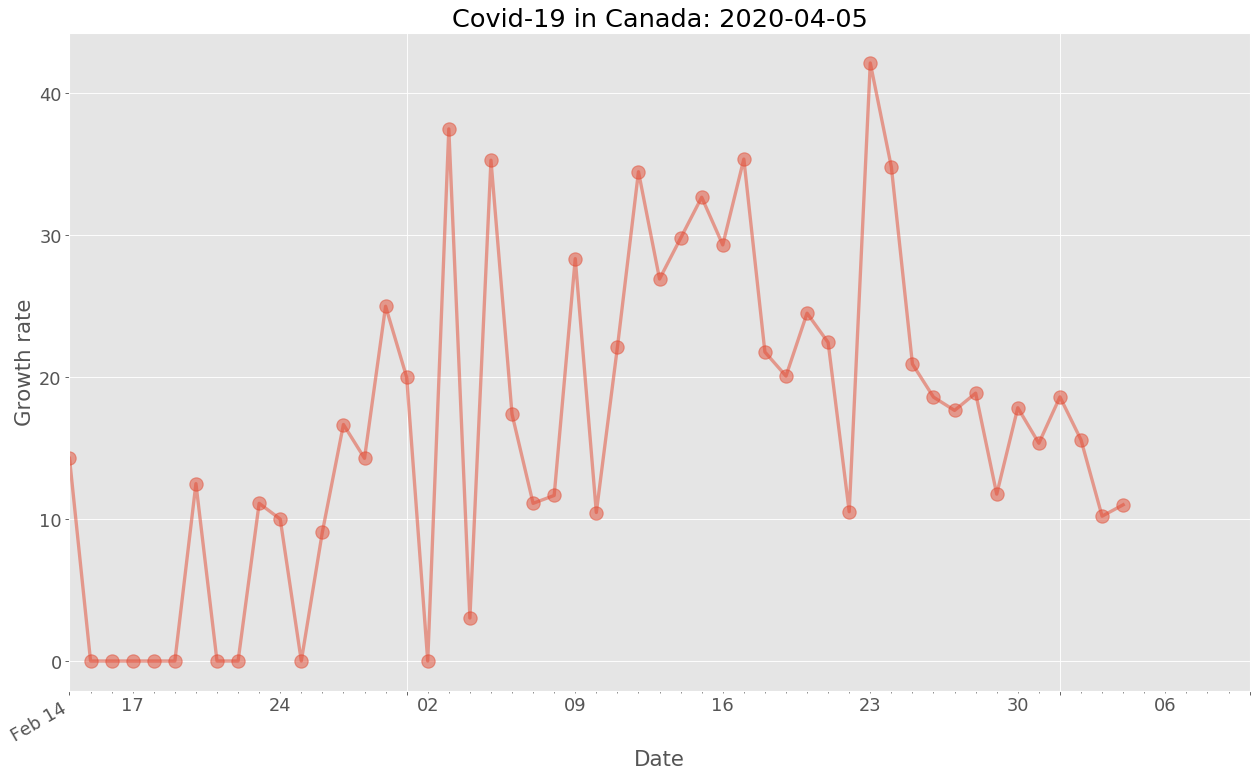

In [390]:
def plot_agg(data, column="cumulative", scale="linear", start_days_after=START_DAYS_AFTER):
    # Use days as the x axis, which are days from 1970-01-01 or so (numbers like 18345)
    data = data.iloc[start_days_after:]
    data.plot(
        kind="line", y=column, linewidth=3,
        marker='o',markersize=12, legend=None, alpha=0.5,
        title="Covid-19 in Canada: " + str(datetime.datetime.today().date())
    )
    # annotate recent values, for linear plots
    plt.yscale(scale)
    if scale=="linear" and column=="cumulative":
        for x,y in zip(data["date"].to_list()[-DAYS_ANNOTATE:], data[column].to_list()[-DAYS_ANNOTATE:]):
            label = "{}".format(int(y))
            plt.annotate(label, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(-5,0), # distance from text to points (x,y)
                         ha="right") # horizontal
        plt.ylim(bottom=0, top=data[column].max() * 1.1)
    elif scale=="log":
        pass
    plt.xlim(left=data["date"].min(),
             right=data["date"].max() + datetime.timedelta(days=6))
    # minor ticks every day
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(base=1))
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(data.index)
    # Every 7th ticklable shows the month and day
    ticklabels[::7] = [item.strftime('%b %d') for item in data.index[::7]]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    #plt.gca().xaxis.set_minor_formatter(ticker.FixedFormatter(['']*len(data.index)))
    plt.gcf().autofmt_xdate(ha="right")
    plt.gca().set_xlabel("Date")
    if column=="cumulative":
        plt.gca().set_ylabel("Cumulative cases")
    elif column=="growth_rate":
        plt.gca().set_ylabel("Growth rate")       
    plt.tight_layout()
    plt.show()
    
plot_agg(data=df_agg[["date_report", "date", "days", "cumulative", "growth_rate"]],
            column="cumulative", scale="linear", start_days_after=20)
plot_agg(data=df_agg[["date_report", "date", "days", "cumulative", "growth_rate"]],
            column="growth_rate", scale="linear", start_days_after=20)

# Curve fitting

Here I am using an exponential function, which is obviously pessimistic over long times, and a quadratic fit too. But let's see if the exponent comes down over time.

In [391]:
df_agg.iloc[-FIT_POINTS:]

,date_report,date,days,cumulative,cumulative_shift,growth_rate
2020-03-26,634,2020-03-26,61,4043.0,3409.0,18.597829
2020-03-27,714,2020-03-27,62,4757.0,4043.0,17.660153
2020-03-28,898,2020-03-28,63,5655.0,4757.0,18.877444
2020-03-29,665,2020-03-29,64,6320.0,5655.0,11.759505
2020-03-30,1128,2020-03-30,65,7448.0,6320.0,17.848101
2020-03-31,1143,2020-03-31,66,8591.0,7448.0,15.346402
2020-04-01,1599,2020-04-01,67,10190.0,8591.0,18.612501
2020-04-02,1588,2020-04-02,68,11778.0,10190.0,15.583906
2020-04-03,1202,2020-04-03,69,12980.0,11778.0,10.205468
2020-04-04,1429,2020-04-04,70,14409.0,12980.0,11.009245


In [392]:
df_agg

,date_report,date,days,cumulative,cumulative_shift,growth_rate
2020-01-25,1,2020-01-25,0,1.0,NaN,NaN
2020-01-26,0,2020-01-26,1,1.0,1.0,0.000000
2020-01-27,1,2020-01-27,2,2.0,1.0,100.000000
2020-01-28,1,2020-01-28,3,3.0,2.0,50.000000
2020-01-29,0,2020-01-29,4,3.0,3.0,0.000000
...,...,...,...,...,...,...
2020-03-31,1143,2020-03-31,66,8591.0,7448.0,15.346402
2020-04-01,1599,2020-04-01,67,10190.0,8591.0,18.612501
2020-04-02,1588,2020-04-02,68,11778.0,10190.0,15.583906
2020-04-03,1202,2020-04-03,69,12980.0,11778.0,10.205468


C:\Users\i826690\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\i826690\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


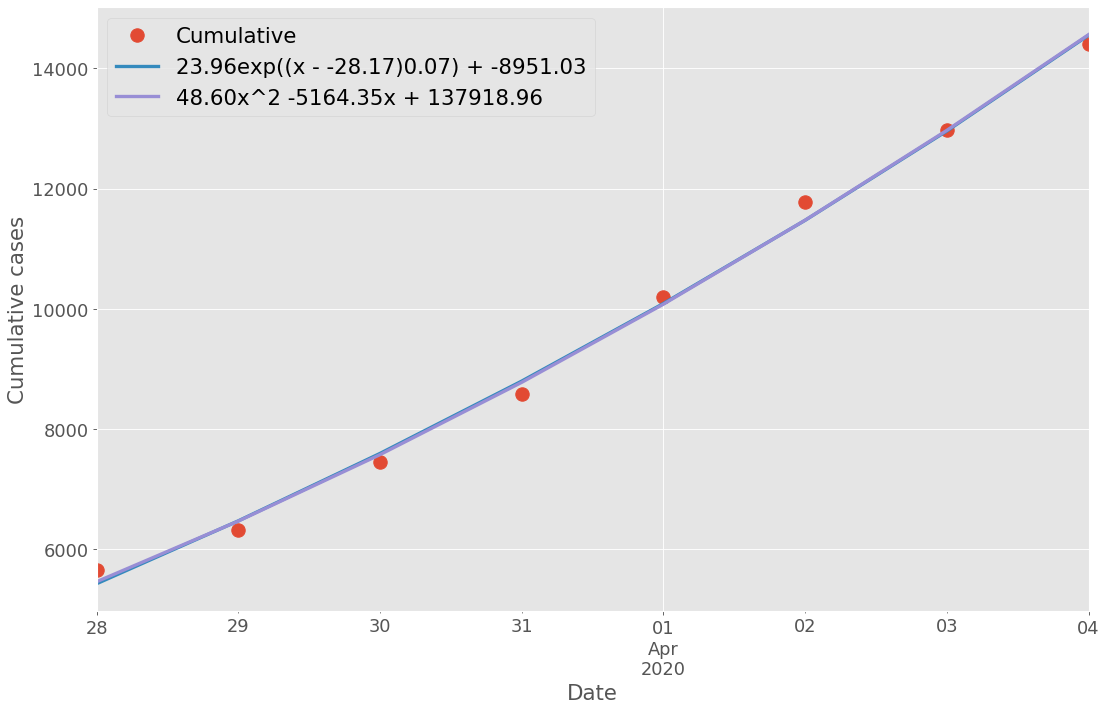

In [393]:
# From http://emilygraceripka.com/blog/14
# curve fit: define the fitting function
def exp_fit(x, a, x0, k, b):
    return a * np.exp((x - x0) * k) + b

def quad_fit(x, a, b, c):
    return a * x * x + b * x + c

def fit_trends(data, fit_points=FIT_POINTS):
    data = data.iloc[-fit_points:]
    x = data["days"]
    y = data["cumulative"]
    # feed it into scipy, method is one of ‘lm’, ‘trf’, ‘dogbox’}
    popt_exp, pcov_exp = curve_fit(exp_fit, x, y, method="trf", p0 = (5,6,0.1,-1000), maxfev = 10000)
    popt_quad, pcov_quad = curve_fit(quad_fit, x, y, maxfev = 10000)
    
    # add columns holding trend values to the dataframe
    data["exp_fit"] = data["days"].apply(lambda x: exp_fit(x, *popt_exp)) 
    data["quad_fit"] = data["days"].apply(lambda x: quad_fit(x, *popt_quad))
    data.plot(kind="line", y=["cumulative", "exp_fit", "quad_fit"], style=["o ", "-", "-"], 
                          label=["Cumulative", 
                                 "{:.2f}exp((x - {:.2f}){:.2f}) + {:.2f}"
                                  .format(*popt_exp),
                                 "{:.2f}x^2 {:-.2f}x + {:.2f}"
                                  .format(*popt_quad)],
                          markersize=12, linewidth=3)
    plt.gca().set_xlabel("Date")
    plt.gca().set_ylabel("Cumulative cases")
    plt.show()
    return (data, popt_exp, popt_quad)

(df_trend, popt_exp, popt_quad) = fit_trends(df_agg, fit_points=8)

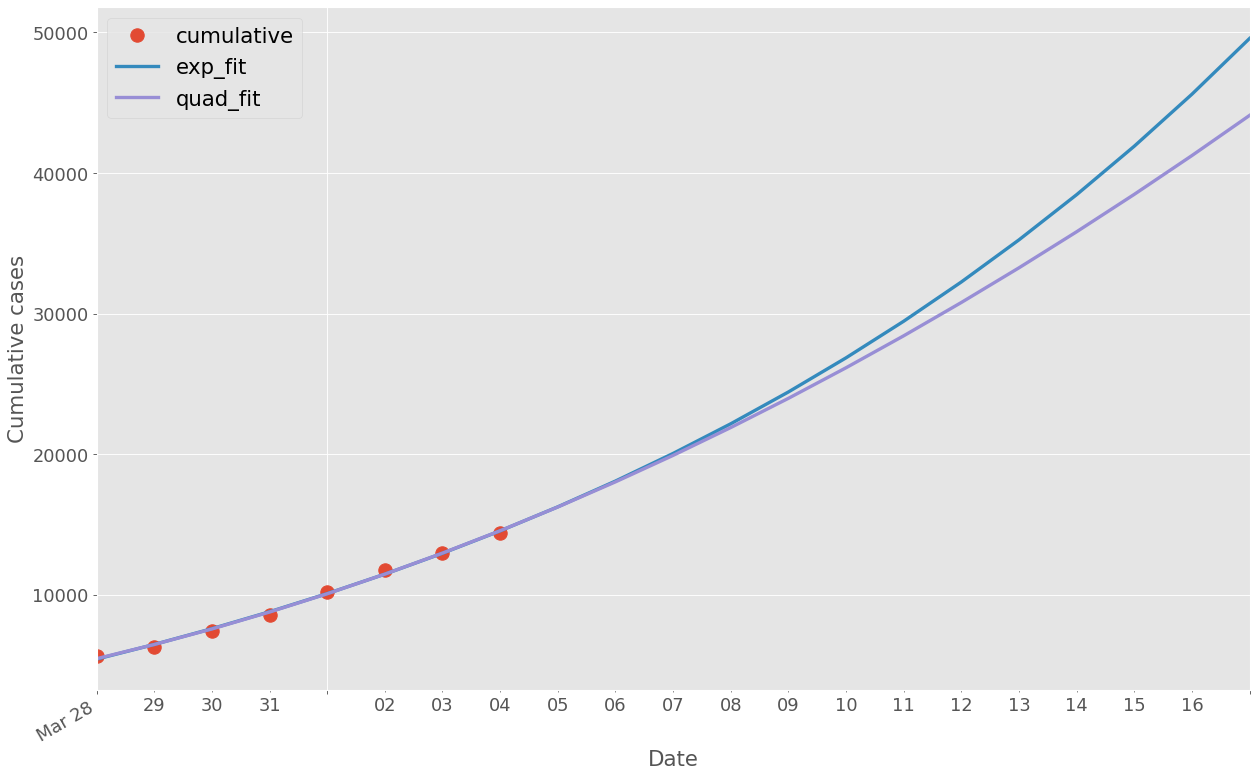

In [394]:
def plot_trends(data, popt_exp, popt_quad, days_extrapolation=DAYS_EXTRAPOLATION):
    data = data[["days", "date", "cumulative", "exp_fit", "quad_fit"]]
    today_row = data.iloc[-1]
    for days in range(1, days_extrapolation):
        this_days = today_row["days"] + days
        this_date = today_row["date"] + datetime.timedelta(days=days)
        data.loc[this_date] = [this_days, this_date.date(), None, 
                                  int(exp_fit(this_days, *popt_exp)),
                                  int(quad_fit(this_days, *popt_quad)),]
    data.plot(
        y=["cumulative", "exp_fit", "quad_fit"], 
        style=["o ", "-", "-"], markersize=12, linewidth=3
    )
    #plt.yscale("log")
    plt.gca().set_xlabel("Date")
    plt.gca().set_ylabel("Cumulative cases") 
     # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(data.index)
    # Every 7th ticklable shows the month and day
    ticklabels[::7] = [item.strftime('%b %d') for item in data.index[::7]]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate(ha="right")
    plt.tight_layout()
    plt.show()
    return data
    
df_trend_extrapolate = plot_trends(df_trend, popt_exp, popt_quad, days_extrapolation=14)

Turn these values into some indicators. Doubling time is one, and factor increase in two weeks is another.

In [395]:
# doubling time
def trend_summary(data, fitter):
    trend_values = data.iloc[-DAYS_EXTRAPOLATION:][fitter].to_list()
    for i, x in enumerate(trend_values):
        if x > 2 * trend_values[0]:
            double_days = i
            break
    two_weeks_factor = round(trend_values[13]/trend_values[0])
    two_weeks = 1000 * round(trend_values[13]/1000.0)
    print("Summary for {} trend".format(fitter))
    print("Doubling time = {} days".format(double_days))
    print("In two weeks the cases will increase by a factor of {} for a total of {}".format(two_weeks_factor, two_weeks))
    print("-" * 80)
trend_summary(df_trend_extrapolate, "exp_fit")
trend_summary(df_trend_extrapolate, "quad_fit")

Summary for exp_fit trend
Doubling time = 7 days
In two weeks the cases will increase by a factor of 3 for a total of 50000
--------------------------------------------------------------------------------
Summary for quad_fit trend
Doubling time = 8 days
In two weeks the cases will increase by a factor of 3 for a total of 44000
--------------------------------------------------------------------------------


# New cases per day

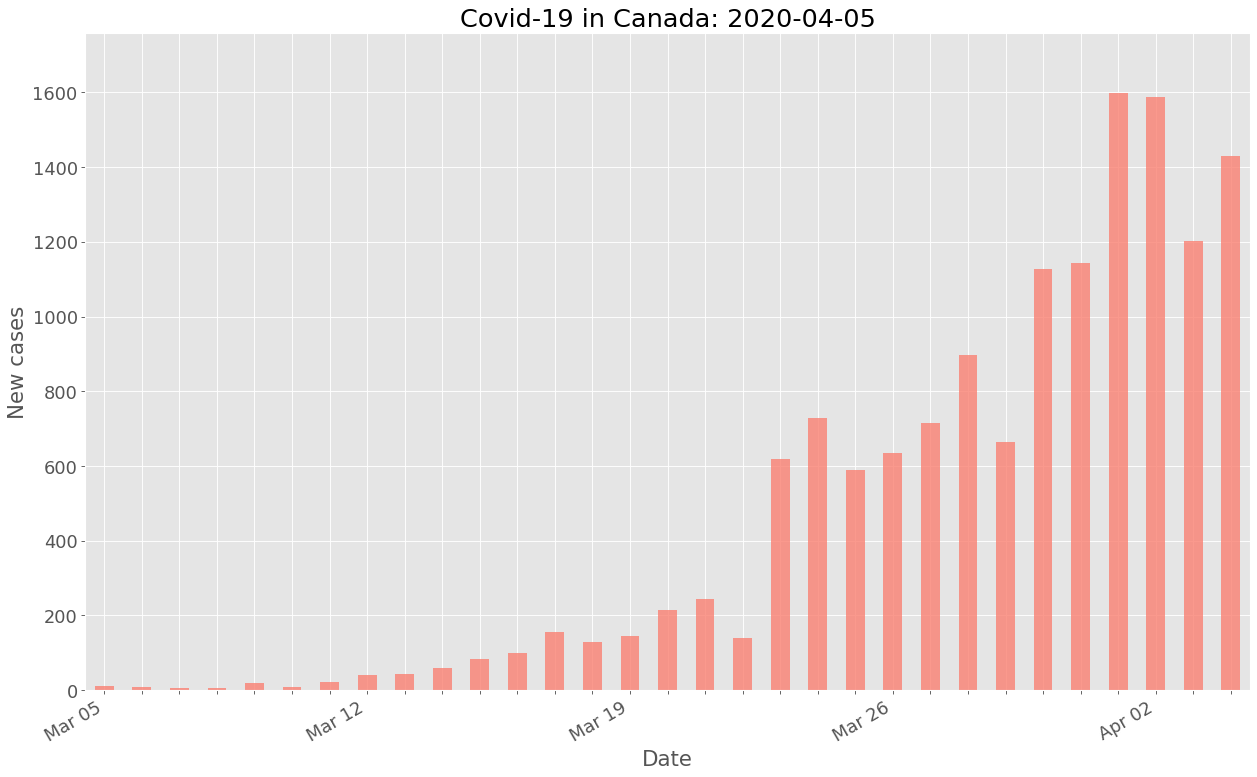

In [396]:
def plot_new_cases(data, start_days_after=START_DAYS_AFTER):
    data = data.iloc[start_days_after:]
    data.plot(
        kind="bar", y="date_report", legend=None, 
        color="salmon", alpha=0.8,
        title="Covid-19 in Canada: " + str(datetime.datetime.today().date())
    )
    plt.gca().set_xlabel("Date")
    plt.gca().set_ylabel("New cases")
    #plt.xlim(right=df_agg["date"].max() + datetime.timedelta(days=4))
    plt.ylim(bottom=0, top=data["date_report"].max() * 1.1)
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(data.index)
    # Every 7th ticklable shows the month and day
    ticklabels[::7] = [item.strftime('%b %d') for item in data.index[::7]]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate(ha="right")
    plt.tight_layout()
    plt.show()
    
plot_new_cases(data=df_agg, start_days_after=40)

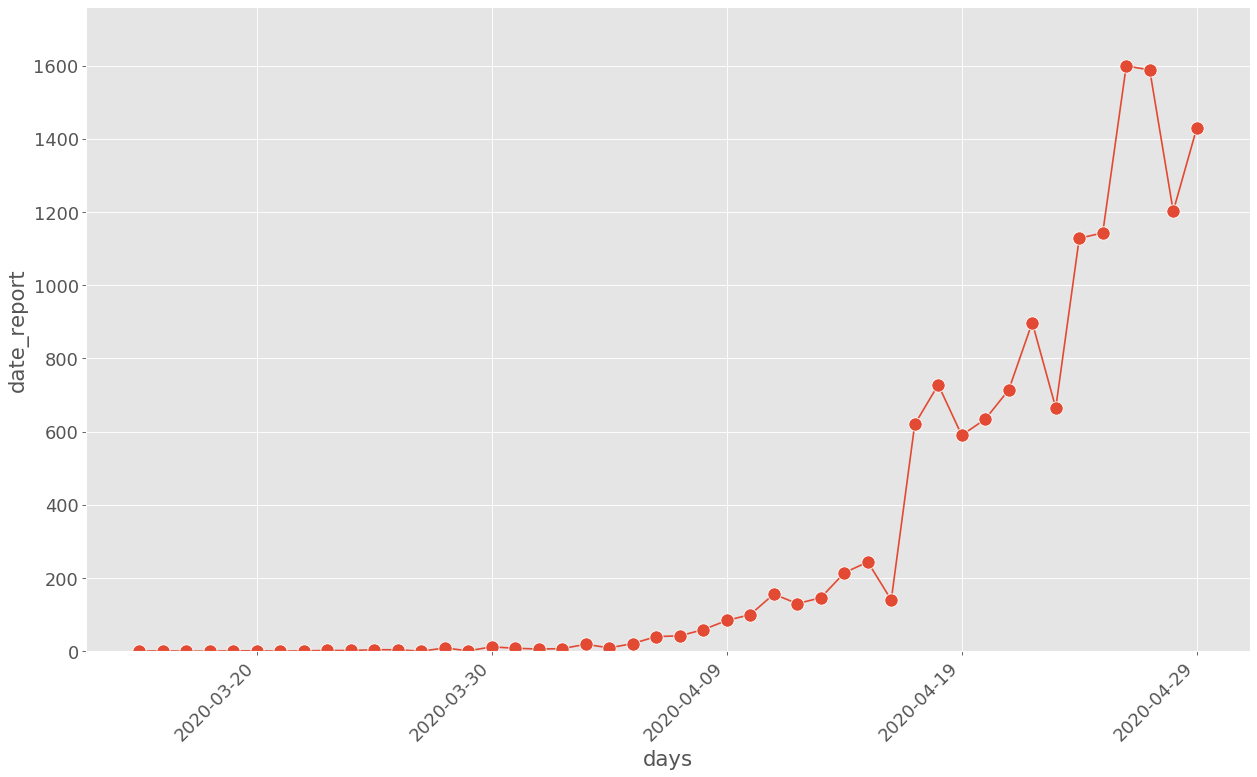

In [397]:
def plot_new_cases_sns(data, start_days_after=START_DAYS_AFTER):
    data = data.iloc[start_days_after:]
    #        plt.figure()
    fig = sns.lineplot(data=data, x="days", y="date_report", marker="o", ms=12)
    # plt.yscale("log")
    # plt.xlim(left=start_days_after, right=df_agg["days"].max() + 1)
    # plt.xlim(left=datetime.date(2020, 3, 1))
    plt.ylim(bottom=0, top=data["date_report"].max() * 1.1)
    new_labels = [(data["date"].min() + datetime.timedelta(days=item)).date()
                  for item in plt.gca().get_xticks()]
    plt.gca().set_xticklabels(new_labels, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
plot_new_cases_sns(df_agg)

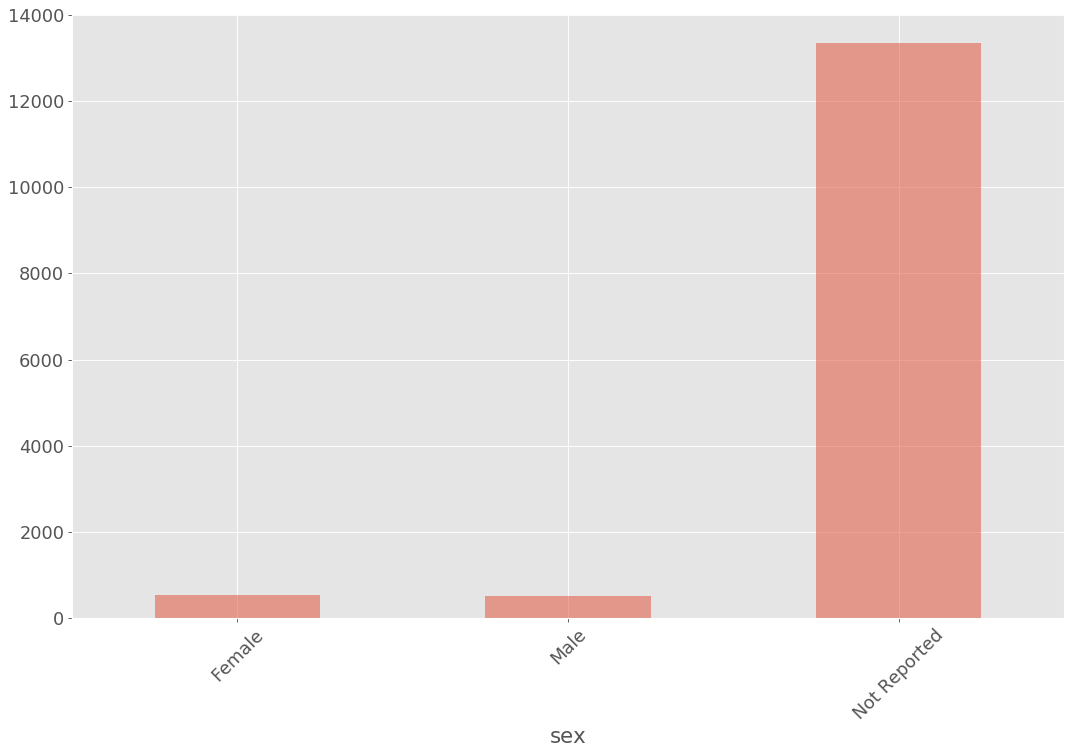

In [398]:
# aggregate by age
df_agg = df["sex"].to_frame().groupby("sex").apply(lambda x: x.count())
df_agg.plot(kind="bar", alpha=0.5, legend=None, rot=45)
plt.show()